<a href="https://colab.research.google.com/github/kmtsui/Colab_Example/blob/main/hivemall_pyspark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hivemall with PySpark

## Installation

Prepare Spark environment for Google Colabo:

In [1]:
# java-11 is already installed...
# !apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://dlcdn.apache.org/spark/spark-3.3.1/spark-3.3.1-bin-hadoop3.tgz
!tar xf spark-3.3.1-bin-hadoop3.tgz
!pip install -q findspark

In [7]:
import os

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.1-bin-hadoop3"

In [8]:
import findspark
findspark.init()

Download Hivemall JAR from the [releases](https://incubator.apache.org/clutch/hivemall.html):

In [ ]:
# hivemall podling has been retired... 
#!wget -q http://mirror.reverse.net/pub/apache/incubator/hivemall/0.5.2-incubating/hivemall-spark2.3-0.5.2-incubating-with-dependencies.jar

## Basic Usage 

Create `SparkSession` with the Hivemall JAR:

In [9]:
# well, start without hivemall
from pyspark.sql import SparkSession

spark = SparkSession \
          .builder \
          .master('local[*]') \
          .config('spark.ui.port', '4050') \
          .enableHiveSupport() \
          .getOrCreate()

`local[*]` runs Spark locally with as many worker threads as logical cores on this environment, and the number is:

In [10]:
!grep -c ^processor /proc/cpuinfo

2


Register Hive(mall) UDFs to the session:

In [ ]:
# no hivemall
# spark.sql("CREATE TEMPORARY FUNCTION hivemall_version AS 'hivemall.HivemallVersionUDF'");

Use the functions in SQL context:

In [ ]:
# spark.sql("SELECT hivemall_version()").show()

## Example: Binary Classification

### Load data

Use a [public dataset](https://aws.amazon.com/blogs/machine-learning/predicting-customer-churn-with-amazon-machine-learning/) that contains customers churn history from a telecom company:

In [32]:
!wget -q https://github.com/kmtsui/Colab_Example/raw/main/DKD2e_data_sets.zip
!unzip -j DKD2e_data_sets.zip "churn.txt"

Archive:  DKD2e_data_sets.zip
  inflating: churn.txt               


Normalize column names, and load data as a Pandas DataFrame:

In [34]:
import re
import pandas as pd

pddf = pd.read_csv('churn.txt') \
         .rename(lambda c: re.sub(r'[^a-zA-Z0-9 ]', '', str(c)).lower().replace(' ', '_'), axis='columns')
pddf.head()

,state,account_length,area_code,phone,intl_plan,vmail_plan,vmail_message,day_mins,day_calls,day_charge,...,eve_calls,eve_charge,night_mins,night_calls,night_charge,intl_mins,intl_calls,intl_charge,custserv_calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


Convert into a Spark DataFrame:

In [35]:
df = spark.createDataFrame(pddf)
df.printSchema()

root
 |-- state: string (nullable = true)
 |-- account_length: long (nullable = true)
 |-- area_code: long (nullable = true)
 |-- phone: string (nullable = true)
 |-- intl_plan: string (nullable = true)
 |-- vmail_plan: string (nullable = true)
 |-- vmail_message: long (nullable = true)
 |-- day_mins: double (nullable = true)
 |-- day_calls: long (nullable = true)
 |-- day_charge: double (nullable = true)
 |-- eve_mins: double (nullable = true)
 |-- eve_calls: long (nullable = true)
 |-- eve_charge: double (nullable = true)
 |-- night_mins: double (nullable = true)
 |-- night_calls: long (nullable = true)
 |-- night_charge: double (nullable = true)
 |-- intl_mins: double (nullable = true)
 |-- intl_calls: long (nullable = true)
 |-- intl_charge: double (nullable = true)
 |-- custserv_calls: long (nullable = true)
 |-- churn: string (nullable = true)



In [36]:
df.toPandas().describe()

,account_length,area_code,vmail_message,day_mins,day_calls,day_charge,eve_mins,eve_calls,eve_charge,night_mins,night_calls,night_charge,intl_mins,intl_calls,intl_charge,custserv_calls
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856
std,39.822106,42.371290,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000
50%,101.000000,415.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,510.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000
max,243.000000,510.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


In [37]:
df.toPandas()['account_length'].describe()

count    3333.000000
mean      101.064806
std        39.822106
min         1.000000
25%        74.000000
50%       101.000000
75%       127.000000
max       243.000000
Name: account_length, dtype: float64

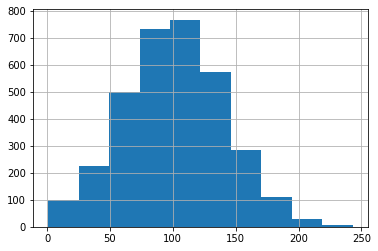

In [38]:
df.toPandas()['account_length'].hist()

### Preprocessing

In [ ]:
spark.sql("CREATE TEMPORARY FUNCTION array_concat AS 'hivemall.tools.array.ArrayConcatUDF'")
spark.sql("CREATE TEMPORARY FUNCTION categorical_features AS 'hivemall.ftvec.trans.CategoricalFeaturesUDF'")
spark.sql("CREATE TEMPORARY FUNCTION quantitative_features AS 'hivemall.ftvec.trans.QuantitativeFeaturesUDF'")
spark.sql("CREATE TEMPORARY FUNCTION rescale AS 'hivemall.ftvec.scaling.RescaleUDF'");

Create a view on the original DataFrame:

In [ ]:
df.createOrReplaceTempView('churn')

Query the view:

In [ ]:
df_preprocessed = spark.sql("""
SELECT
  phone,
  array_concat(
    categorical_features(
      array('intl_plan', 'state', 'area_code', 'vmail_plan'),
      intl_plan, state, area_code, vmail_plan
    ),
    quantitative_features(
      array(
        'night_charge', 'day_charge', 'custserv_calls', 
        'intl_charge', 'eve_charge', 'vmail_message'
      ),
      night_charge, day_charge, custserv_calls,
      intl_charge, eve_charge, vmail_message
    )
  ) as features,
  if(churn = 'True.', 1, 0) as label
FROM
  churn
""")
df_preprocessed.toPandas().head()

,phone,features,label
0,382-4657,"[intl_plan#no, state#KS, area_code#415, vmail_...",0
1,371-7191,"[intl_plan#no, state#OH, area_code#415, vmail_...",0
2,358-1921,"[intl_plan#no, state#NJ, area_code#415, vmail_...",0
3,375-9999,"[intl_plan#yes, state#OH, area_code#408, vmail...",0
4,330-6626,"[intl_plan#yes, state#OK, area_code#415, vmail...",0


We can of course run Spark DataFrame operations:

In [ ]:
df_preprocessed.groupby('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1|  483|
|    0| 2850|
+-----+-----+



Split records into 80% train and 20% test set:

In [ ]:
df_train, df_test = df_preprocessed.randomSplit([0.8, 0.2], seed=31)
df_train.count(), df_test.count()

(2658, 675)

### Training

Use `train_classifier` UDF to build a liner classifier:

In [ ]:
spark.sql("CREATE TEMPORARY FUNCTION train_classifier AS 'hivemall.classifier.GeneralClassifierUDTF'");

Usage can be found by `-help` option:

In [ ]:
spark.sql("SELECT train_classifier(array(), 0, '-help')")

AnalysisException: ignored

Train a model in the distributed manner by leveraging the available workers:

In [ ]:
df_train.createOrReplaceTempView('train')

df_model = spark.sql("""
SELECT
  feature,
  avg(weight) as weight
FROM (
  SELECT
    train_classifier(
      features, 
      label,
      '-loss logloss -opt SGD -reg l1 -lambda 0.03 -eta0 0.01'
    ) as (feature, weight)
  FROM
    train
) t
GROUP BY 1
""")
df_model.toPandas().head(10)

,feature,weight
0,state#TX,0.088104
1,state#MN,0.024230
2,state#LA,-0.024339
3,area_code#408,-0.006044
4,night_charge,-0.194483
5,state#ND,-0.066669
6,state#VT,-0.063177
7,state#MA,0.000016
8,state#OH,0.031865
9,state#MD,0.038399


Model parameters can be easily visualized as:

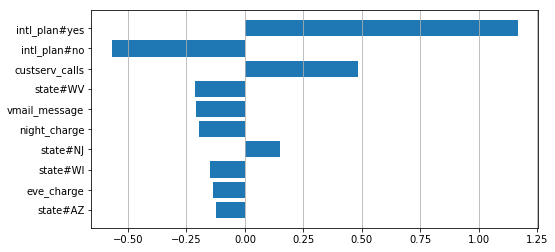

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import pyspark.sql.functions as F

m = df_model.orderBy(F.abs(df_model.weight).desc()).limit(10).toPandas()

x = range(m.shape[0])
plt.barh(x, m['weight'], align='center')
plt.yticks(x, m['feature'])

plt.gca().invert_yaxis()
plt.gca().xaxis.grid(True)

fig = plt.gcf()
fig.set_size_inches((8, 4))
    
plt.show()

### Prediction

In [ ]:
spark.sql("CREATE TEMPORARY FUNCTION sigmoid AS 'hivemall.tools.math.SigmoidGenericUDF'")
spark.sql("CREATE TEMPORARY FUNCTION extract_feature AS 'hivemall.ftvec.ExtractFeatureUDFWrapper'")
spark.sql("CREATE TEMPORARY FUNCTION extract_weight AS 'hivemall.ftvec.ExtractWeightUDFWrapper'");

Join over features, compute weighted sum of them, and take sigmoid:

In [ ]:
df_test.createOrReplaceTempView('test')
df_model.createOrReplaceTempView('model')

df_prediction = spark.sql("""
SELECT
  phone,
  label as expected,
  sigmoid(sum(weight * value)) as prob
FROM ( 
  SELECT
    phone,
    label,
    extract_feature(fv) AS feature,
    extract_weight(fv) AS value
  FROM 
    test
  LATERAL VIEW explode(features) t2 AS fv
) t 
LEFT OUTER JOIN model m 
  ON t.feature = m.feature
GROUP BY 1, 2
""")
df_prediction.toPandas().head(10)

,phone,expected,prob
0,375-3003,0,0.043165
1,344-4022,0,0.032754
2,356-2992,0,0.000035
3,420-3028,0,0.009459
4,354-9062,0,0.128704
5,360-6024,0,0.000029
6,376-4705,1,0.019202
7,373-1448,1,0.007880
8,349-2157,0,0.009182
9,337-9569,0,0.052731


### Evaluation

For binary classification, Hivemall offers [Log Loss](http://wiki.fast.ai/index.php/Log_Loss) and [AUC](http://gim.unmc.edu/dxtests/ROC3.htm) metric:

In [ ]:
spark.sql("CREATE TEMPORARY FUNCTION logloss AS 'hivemall.evaluation.LogarithmicLossUDAF'")
spark.sql("CREATE TEMPORARY FUNCTION auc AS 'hivemall.evaluation.AUCUDAF'");

In [ ]:
df_prediction.createOrReplaceTempView('prediction')

spark.sql("""
SELECT
  auc(prob, expected) AS auc,
  logloss(prob, expected) AS logloss
FROM (
  SELECT prob, expected
  FROM prediction
  ORDER BY prob DESC
) t
""").show()

+------------------+------------------+
|               auc|           logloss|
+------------------+------------------+
|0.6360049076499652|0.6456736373258979|
+------------------+------------------+



## Other Classifiers

### Factorization Machines

In [ ]:
spark.sql("CREATE TEMPORARY FUNCTION train_fm AS 'hivemall.fm.FactorizationMachineUDTF'");

In [ ]:
spark.sql("""
SELECT
  train_fm(
    features, 
    label,
    '-classification -factor 30 -eta 0.001'
  ) as (feature, Wi, Vij)
FROM
  train
""").toPandas().head(10)

,feature,Wi,Vij
0,0,-0.125796,None
1,state#SC,-0.002943,"[-0.0018758076475933194, 0.06696834415197372, ..."
2,area_code#408,-0.043842,"[-0.022054938599467278, 0.007548300549387932, ..."
3,vmail_message,-0.070304,"[0.013247097842395306, 0.005205452907830477, 0..."
4,state#WV,-0.033708,"[-0.07025326788425446, -0.14394021034240723, -..."
5,state#NC,0.002798,"[0.06377897411584854, -0.09058145433664322, -0..."
6,state#KY,0.002730,"[0.06627880781888962, -0.14982153475284576, -0..."
7,intl_charge,-0.042286,"[-0.06048768013715744, 0.018183737993240356, 0..."
8,state#CO,0.019807,"[0.03619685024023056, 0.09739864617586136, -0...."
9,state#VA,-0.019707,"[-0.09031106531620026, 0.14337880909442902, -0..."


### RandomFores

In [ ]:
spark.sql("CREATE TEMPORARY FUNCTION feature_hashing AS 'hivemall.ftvec.hashing.FeatureHashingUDF'")
spark.sql("CREATE TEMPORARY FUNCTION tree_predict AS 'hivemall.smile.tools.TreePredictUDF'")
spark.sql("CREATE TEMPORARY FUNCTION rf_ensemble AS 'hivemall.smile.tools.RandomForestEnsembleUDAF'")
spark.sql("CREATE TEMPORARY FUNCTION train_randomforest_classifier AS 'hivemall.smile.classification.RandomForestClassifierUDTF'")
spark.sql("CREATE TEMPORARY FUNCTION tree_export AS 'hivemall.smile.tools.TreeExportUDF'");

Training:

In [ ]:
df_rf_model = spark.sql("""
SELECT
  train_randomforest_classifier(
    feature_hashing(features),
    label,
    '-trees 50 -seed 71' -- hyperparameters
  ) as (model_id, model_weight, model, var_importance, oob_errors, oob_tests)
FROM
  train
""")

df_rf_model.toPandas().head()

,model_id,model_weight,model,var_importance,oob_errors,oob_tests
0,a3967714-914e-4267-b3f0-788fbef8225a,0.837838,I?XPI/%dsLd{LdDfaZTPM:)_@^i12w<Ba)_j40icEw3jYE...,{15900165: 1.8062073885289325},0,0
1,814a7805-f1b2-4799-a66a-722f96233bc5,0.816498,I?{Pt:IYsLd{3Ze;DYt:3%}g`]F:N}gYMLrRqViFPHu._X...,{15900165: 2.7499708167499106},0,0
2,bea6eef6-d8d8-43ba-861e-217386e32be4,0.851724,I?{PI/%dsLd{2Yw+<LzSF`agXnUPzzou^7Yl[Pws[y~yzD...,{15900165: 2.4154606004599684},0,0
3,cfb19b11-4afb-4d5a-a2de-b3d1e940a098,0.807692,I?{P)`IYwL$|yz6!AGW.%p~UV=-B)WoH=;0c8uOOj+{BiM...,{15900165: 3.886217162213024},0,0
4,efe91459-c0d5-4acf-953a-3c62c35f8f0d,0.824503,I?hRO|IYsL$|+Z>ZwzRhE`><L`+-vZ>D]1UblfV48c=Cl4...,{15900165: 3.422917848419591},0,0


Prediction:

In [ ]:
df_rf_model.createOrReplaceTempView('rf_model')

spark.sql("""
SELECT
  phone,
  rf_ensemble(predicted.value, predicted.posteriori, model_weight) as predicted
FROM (
  SELECT
    t.phone,
    m.model_weight,
    tree_predict(m.model_id, m.model, feature_hashing(t.features), true) as predicted
  FROM
    test t
  CROSS JOIN
    rf_model m
) t1
GROUP BY
  1
""").toPandas().head(10)

,phone,predicted
0,366-3944,"(0, 1.0, [1.0, 0.0])"
1,378-4013,"(0, 0.9572407298262462, [0.9572407298262462, 0..."
2,385-9744,"(0, 1.0, [1.0, 0.0])"
3,408-4529,"(0, 0.8680956719420105, [0.8680956719420105, 0..."
4,355-6422,"(0, 1.0, [1.0, 0.0])"
5,373-2053,"(0, 0.803639476792548, [0.803639476792548, 0.1..."
6,341-1916,"(0, 0.9793229251609381, [0.9793229251609381, 0..."
7,368-8972,"(0, 1.0, [1.0, 0.0])"
8,383-4641,"(0, 1.0, [1.0, 0.0])"
9,386-3796,"(0, 0.6022822895905967, [0.6022822895905967, 0..."


Visualization:

In [ ]:
df_rf_model_viz = spark.sql("""
SELECT
  tree_export(model, '-type javascript') as js,
  tree_export(model, '-type graphviz') as dot
FROM
  rf_model
""")

df_rf_model_viz.toPandas().head()

,js,dot
0,if( x[15900165] <= 6.225 ) {\n if( x[15900165...,"digraph Tree {\n node [shape=box, style=""fille..."
1,if( x[15900165] <= 5.755 ) {\n if( x[15900165...,"digraph Tree {\n node [shape=box, style=""fille..."
2,if( x[15900165] <= 5.395 ) {\n if( x[15900165...,"digraph Tree {\n node [shape=box, style=""fille..."
3,if( x[15900165] <= 3.74 ) {\n if( x[15900165]...,"digraph Tree {\n node [shape=box, style=""fille..."
4,if( x[15900165] <= 6.015 ) {\n if( x[15900165...,"digraph Tree {\n node [shape=box, style=""fille..."


In [ ]:
viz_sample_row = df_rf_model_viz.limit(1).collect()[0]

print(viz_sample_row.js)

if( x[15900165] <= 6.225 ) {
  if( x[15900165] <= 5.425000000000001 ) {
    if( x[15900165] <= 4.85 ) {
      if( x[15900165] <= 3.3499999999999996 ) {
        0;
      } else  {
        0;
      }
    } else  {
      0;
    }
  } else  {
    if( x[15900165] <= 6.02 ) {
      0;
    } else  {
      0;
    }
  }
} else  {
  if( x[15900165] <= 6.25 ) {
    1;
  } else  {
    if( x[15900165] <= 8.41 ) {
      if( x[15900165] <= 8.395 ) {
        if( x[15900165] <= 6.359999999999999 ) {
          0;
        } else  {
          if( x[15900165] <= 6.445 ) {
            0;
          } else  {
            if( x[15900165] <= 6.735 ) {
              if( x[15900165] <= 6.615 ) {
                0;
              } else  {
                0;
              }
            } else  {
              if( x[15900165] <= 6.745 ) {
                1;
              } else  {
                if( x[15900165] <= 6.825 ) {
                  0;
                } else  {
                  if( x[15900165] <= 6.835 ) 

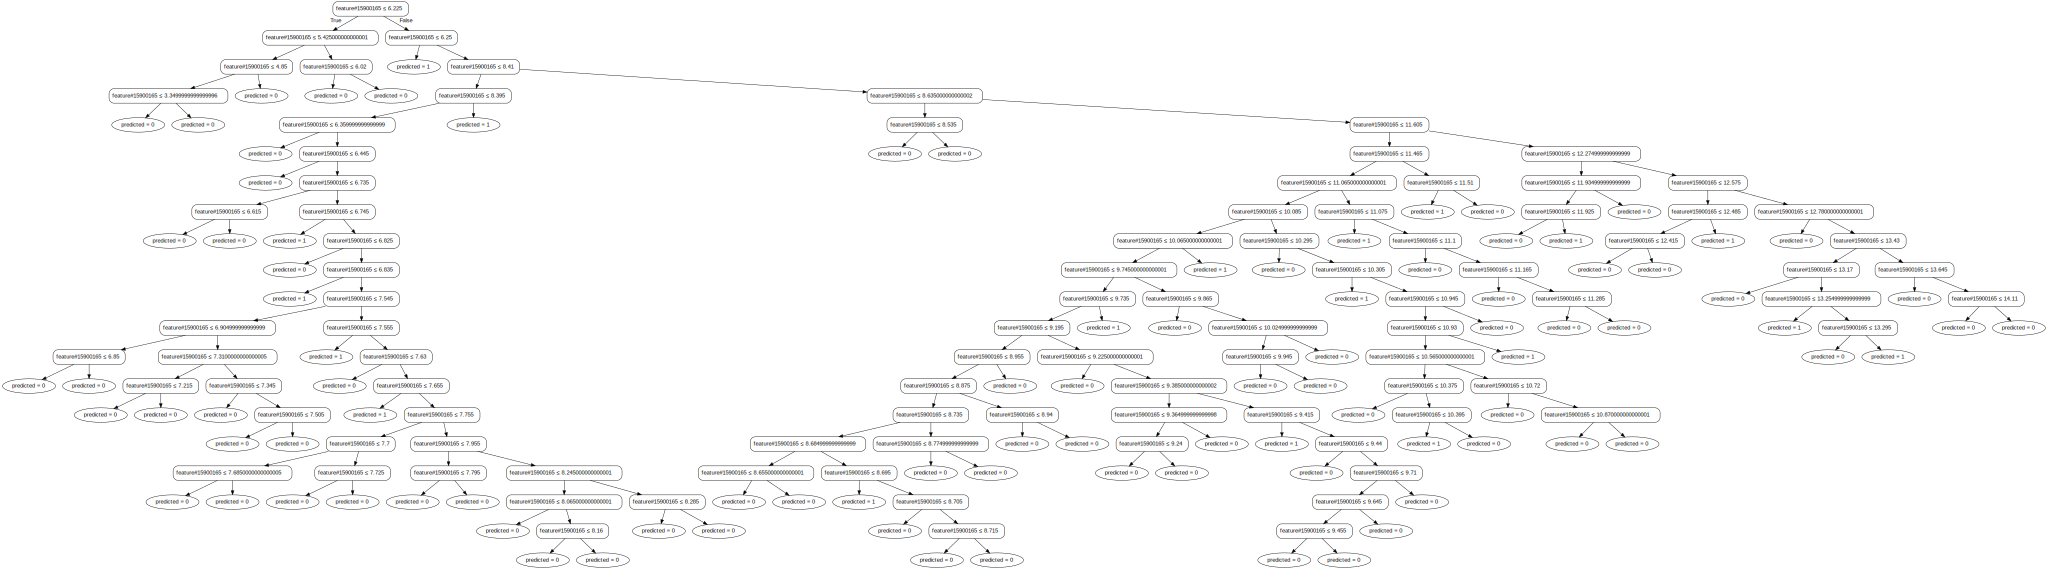

In [ ]:
from graphviz import Source

Source(viz_sample_row.dot)

## Leveraging Python/PySpark More

Preprocessing can be easy:

In [ ]:
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=['account_length'], 
    outputCol="account_length_vect"
)
scaler = MinMaxScaler(
    inputCol="account_length_vect", 
    outputCol="account_length_scaled"
)

pipeline = Pipeline(stages=[assembler, scaler])
pipeline.fit(df) \
        .transform(df) \
        .select([
          'account_length', 'account_length_vect', 
          'account_length_scaled'
        ]).show()

+--------------+-------------------+---------------------+
|account_length|account_length_vect|account_length_scaled|
+--------------+-------------------+---------------------+
|           128|            [128.0]| [0.5247933884297521]|
|           107|            [107.0]| [0.4380165289256198]|
|           137|            [137.0]| [0.5619834710743802]|
|            84|             [84.0]| [0.34297520661157...|
|            75|             [75.0]| [0.30578512396694...|
|           118|            [118.0]| [0.4834710743801653]|
|           121|            [121.0]| [0.49586776859504...|
|           147|            [147.0]| [0.6033057851239669]|
|           117|            [117.0]| [0.4793388429752066]|
|           141|            [141.0]| [0.5785123966942148]|
|            65|             [65.0]| [0.2644628099173554]|
|            74|             [74.0]| [0.30165289256198...|
|           168|            [168.0]| [0.6900826446280992]|
|            95|             [95.0]| [0.3884297520661157

Dynamically generate the training query:

In [ ]:
q = """
SELECT
  feature,
  avg(weight) as weight
FROM (
  SELECT
    train_classifier(
      features, 
      label,
      '-loss logloss -opt SGD -reg l1 -lambda {0} -eta0 {1}'
    ) as (feature, weight)
  FROM
    train
) t
GROUP BY 1
"""

hyperparams = [
    (0.01, 0.01),
    (0.03, 0.01),
    (0.03, 0.03),
    ( 0.1, 0.03)
    # ...
]

for reg_lambda, eta0 in hyperparams:
  sql.spark(q.format(reg_lambda, eta0))


SELECT
  feature,
  avg(weight) as weight
FROM (
  SELECT
    train_classifier(
      features, 
      label,
      '-loss logloss -opt SGD -reg l1 -lambda 0.01 -eta0 0.01'
    ) as (feature, weight)
  FROM
    train
) t
GROUP BY 1


SELECT
  feature,
  avg(weight) as weight
FROM (
  SELECT
    train_classifier(
      features, 
      label,
      '-loss logloss -opt SGD -reg l1 -lambda 0.03 -eta0 0.01'
    ) as (feature, weight)
  FROM
    train
) t
GROUP BY 1


SELECT
  feature,
  avg(weight) as weight
FROM (
  SELECT
    train_classifier(
      features, 
      label,
      '-loss logloss -opt SGD -reg l1 -lambda 0.03 -eta0 0.03'
    ) as (feature, weight)
  FROM
    train
) t
GROUP BY 1


SELECT
  feature,
  avg(weight) as weight
FROM (
  SELECT
    train_classifier(
      features, 
      label,
      '-loss logloss -opt SGD -reg l1 -lambda 0.1 -eta0 0.03'
    ) as (feature, weight)
  FROM
    train
) t
GROUP BY 1



Many other evaluation metrics can be taken from MLlib:

In [ ]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics

metrics = BinaryClassificationMetrics(
    df_prediction.select(
        df_prediction.prob, 
        df_prediction.expected.cast('float')
    ).rdd.map(tuple)
)

metrics.areaUnderPR, metrics.areaUnderROC

(0.25783248058994873, 0.6360049076499648)